# **Business Objectives and Its Context**



The business objective is to help improving road safety in the UK, by developing a predictive model that is able to predict accident severity based on various external variables. We would be a government agency trying to find out where to deploy resources for in order to enhance road safety. 

We will use data from the UK Government website: https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

The website provides datasets regarding road safety in the UK, and we are going to use the containing data about accidents occured in 2019 given some external and internal factors. Due to the business objective and the context we have supposed to play in, we will only be using external factors data. Lastly, 2019 data are the latest available at this time. 



 




# **Descriptive statistics on the dataset**


Firstly, we need to read the dataset to start working on it. Notice that we have already selected specific variables amongst them all that will suit our analysis best. They are all referring to external factors to hold the assmption of our business objective. 

In [ ]:
#Import Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

#Preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
#Store the dataset file in a variable 
file = "Road Safety Data - Accidents 2019.csv"

#Select the columns to read from the original dataset 
columns = ["Accident_Index", "Accident_Severity", "Road_Type","Light_Conditions","Speed_limit","Road_Surface_Conditions",
           "Special_Conditions_at_Site","Carriageway_Hazards","Urban_or_Rural_Area","Number_of_Vehicles","Latitude","Longitude",
           "Location_Easting_OSGR","Location_Northing_OSGR","Date","Weather_Conditions", "Time", "Day_of_Week"]

#Read the dataset with pandas, set the accident index variable as index 
df = pd.read_csv(file, usecols=columns, low_memory=False).set_index("Accident_Index")

Let's have a glimpse of the dataset in respect of variable types, missing values, number of raws and columns and some descriptive statistics to get a better idea of the data

In [ ]:
#Number of instances and features in the dataset 
df.shape

(117536, 17)

In [ ]:
#Get the variable type, columns names and number of rows 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117536 entries, 2019010128300 to 201998QC01004
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Location_Easting_OSGR       117508 non-null  float64
 1   Location_Northing_OSGR      117508 non-null  float64
 2   Longitude                   117508 non-null  float64
 3   Latitude                    117508 non-null  float64
 4   Accident_Severity           117536 non-null  int64  
 5   Number_of_Vehicles          117536 non-null  int64  
 6   Date                        117536 non-null  object 
 7   Day_of_Week                 117536 non-null  int64  
 8   Time                        117473 non-null  object 
 9   Road_Type                   117536 non-null  int64  
 10  Speed_limit                 117536 non-null  int64  
 11  Light_Conditions            117536 non-null  int64  
 12  Weather_Conditions          117536 non-null  int64  
 13  

In [ ]:
#How many missing values in the dataset 
df.isnull().sum()

Location_Easting_OSGR         28
Location_Northing_OSGR        28
Longitude                     28
Latitude                      28
Accident_Severity              0
Number_of_Vehicles             0
Date                           0
Day_of_Week                    0
Time                          63
Road_Type                      0
Speed_limit                    0
Light_Conditions               0
Weather_Conditions             0
Road_Surface_Conditions        0
Special_Conditions_at_Site     0
Carriageway_Hazards            0
Urban_or_Rural_Area            0
dtype: int64

In [ ]:
#Randomly retrive ten rows from the dataset 
df.sample(10)

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Date,Day_of_Week,Time,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area
Accident_Index,,,,,,,,,,,,,,,,,
2019450877247,519286.0,153889.0,-0.291383,51.271674,3,2,13/09/2019,6,08:45,6,60,1,1,1,0,0,2
2019910887102,183082.0,827263.0,-5.600787,57.284298,2,1,11/10/2019,6,19:00,6,60,6,2,2,0,0,2
2019230924289,452820.0,274424.0,-1.225693,52.365347,3,2,17/11/2019,1,10:45,3,30,1,1,1,0,0,1
2019220841269,373314.0,309861.0,-2.396207,52.685792,1,1,19/05/2019,1,00:30,6,60,6,1,1,0,0,2
2019430123473,487598.0,234513.0,-0.725342,52.002166,3,1,23/04/2019,3,13:30,6,30,1,1,1,0,0,1
2019010158185,513629.0,172696.0,-0.366441,51.441869,3,2,17/01/2019,5,16:45,3,40,7,1,1,0,0,1
2019121900317,463226.0,450705.0,-1.038144,53.948611,3,3,04/02/2019,2,19:26,6,30,4,1,2,0,0,1
201906N262818,381177.0,404062.0,-2.285447,53.532888,2,1,06/10/2019,1,19:30,6,30,4,1,1,0,0,1
2019320164883,526767.0,323996.0,-0.121198,52.798660,3,3,01/04/2019,2,12:30,6,40,1,1,1,0,0,2


We can notice that some variables which are supposed to be categorical have been encoded as numerical. Indeed, they have got numbers rather than categorie levels. Moreover, the date feature has the object type instead of datetime. We will sort all of these things out in the next step.

## Convert Columns to Correct Datatype

All the categorical variables in the dataset have been stored as numerical, whereby each number corresponds to a specific category. As a first step we will then convert all these variables to their correct datatype converting each values to its corresponding category. 

Let's start with encoding the date variable properly using pandas. 

In [ ]:
#Convert the date variable 
df["Date"]=pd.to_datetime(df['Date'], format="%d/%m/%Y")

#Check the type 
print(df["Date"].dtypes)

datetime64[ns]


We can go further extrapolating the month and season variable from the date feature. 

In [ ]:
# Create new variable month
df['month'] = df['Date'].dt.month

In [ ]:
# create a column for seasons
def month_season(row):
    month = row['month']
    if  month==12 or month<=2 :# winter (December, January, February)
        return "Winter"
    elif month<=5:# spring (March, April, May) 
        return "Spring"
    elif month<=8:# summer (June, July, August)
        return "Summer"
    elif month<=11:# autumn (September, October, November)
        return "Autumn"

df["season"] = df.apply(month_season, axis=1)

df.drop("month", axis=1, inplace=True)

The date variable has been now converted to its correct datatype. Let's now convert all the categorical variables' levels from number to its corresponding value. 

In [ ]:
# use nominal values for Weather conditions
replacement_dict_weather = {
    1: "Fine no high winds",
    2: "Raining no high winds",
    3: "Snowing no high winds",
    4: "Fine + high winds",
    5: "Raining + high winds",
    6: "Snowing + high winds",
    7: "Fog or mist",
    8: "Other",
    9: np.NaN ,
    -1: np.NaN
}

#Convert the values within the variable 
df["Weather_Conditions"] = df["Weather_Conditions"].map(replacement_dict_weather)

#Check the values 
df["Weather_Conditions"].value_counts(ascending=False)

Fine no high winds       92316
Raining no high winds    15294
Other                     3043
Raining + high winds      1430
Fine + high winds         1230
Fog or mist                394
Snowing no high winds      353
Snowing + high winds        40
Name: Weather_Conditions, dtype: int64

We will keep converting and cleaning all the other variables in the same way. 

In [ ]:
# use nominal values for Accident Severity
replacement_dict_acc_sev = {
    1: "Fatal",
    2: "Serious",
    3: "Slight" }

#Convert the values within the variable 
df['Accident_Severity'] = df['Accident_Severity'].map(replacement_dict_acc_sev)

#Check the values 
df["Accident_Severity"].value_counts()

Slight     92456
Serious    23422
Fatal       1658
Name: Accident_Severity, dtype: int64

In [ ]:
# use nominal values for Road Type 
replacement_dict_roadtype = {
    1: "Roundabout",
    2: "One way street",
    3: "Dual carriageway",
    6: "Single carriageway",
    7: "Slip road",
    9: np.NaN }

#Convert the values within the variable
df["Road_Type"] = df["Road_Type"].map(replacement_dict_roadtype)

#Check the values 
df["Road_Type"].value_counts()

Single carriageway    85320
Dual carriageway      18590
Roundabout             6880
One way street         2664
Slip road              1939
Name: Road_Type, dtype: int64

In [ ]:
df["Road_Surface_Conditions"].value_counts()

 1    82321
 2    32259
-1     1349
 4     1185
 3      245
 5      177
Name: Road_Surface_Conditions, dtype: int64

In [ ]:
# use nominal values for Road_Surface
replacement_dict_roadtype = {
    1: "Dry",
    2: "Wet or damp",
    3: "Snow",
    4: "Frost or ice",
    5: "Flood over 3cm. deep",
    -1: np.nan
}

#Replace the value within the variable 
df["Road_Surface_Conditions"] = df["Road_Surface_Conditions"].map(replacement_dict_roadtype)

#Check the converted values 
df["Road_Surface_Conditions"].value_counts()

Dry                     82321
Wet or damp             32259
Frost or ice             1185
Snow                      245
Flood over 3cm. deep      177
Name: Road_Surface_Conditions, dtype: int64

Let's convert 'Light_Conditions" variable values to their corresponding conditions 

In [ ]:
#Check the values in Light Conditions
df["Light_Conditions"].value_counts()

 1    83511
 4    24407
 6     6092
 7     2634
 5      891
-1        1
Name: Light_Conditions, dtype: int64

In [ ]:
# use nominal values for Light_Conditions 
replacement_LightConditions = {
    1: "Daylight",
    4: "Darkness - lights lit",
    5: "Darkness - lights unlit",
    6: "Darkness - no lighting",
    7: "Darkness - lighting unknown",
    -1: "Data missing or out of range"
}

#Replace the value within the dataset 
df["Light_Conditions"] = df["Light_Conditions"].map(replacement_LightConditions)

#Check the values 
df["Light_Conditions"].value_counts()

Daylight                        83511
Darkness - lights lit           24407
Darkness - no lighting           6092
Darkness - lighting unknown      2634
Darkness - lights unlit           891
Data missing or out of range        1
Name: Light_Conditions, dtype: int64

The lighting conditions were agregated into 3 categories: Daylight, Darkness - Artificial light and Darkness - No light, in order to have an idea of the impact of lighting conditions in accident severity.

NOTE: Because the lighting conditions are not known in 2634 cases, we made the assumption of adding them to the no lighting category. It was not treated as missing value, because once we used the imputer, we would lose part of the data (we know it is darkness) by using the most frequent strategy.

In [ ]:
def replace_lightconditions(x): 

  #Replace all the values containg darkness in just darkness, 
  #Replace data missing or out of values in NaN 
  #Keep everithing else the same as it is 

  if "Daylight" == x["Light_Conditions"]: 
    return "Daylight"
  elif "Data missing or out of range" == x["Light_Conditions"]: 
    return np.nan
  elif "Darkness - lights lit" == x["Light_Conditions"]: 
    return "Darkness - Artificial light"
  else:
    return "Darkness - No lighting"

#Apply the function to the Light Condition column 
df["Light_Conditions"] = df.apply(replace_lightconditions, axis = 1)  

#Check the value 
df["Light_Conditions"].value_counts()
      

Daylight                       83511
Darkness - Artificial light    24407
Darkness - No lighting          9617
Name: Light_Conditions, dtype: int64

In [ ]:
df["Special_Conditions_at_Site"].value_counts()

 0    113157
-1      1819
 4      1328
 7       295
 1       276
 5       240
 3       200
 6       183
 2        38
Name: Special_Conditions_at_Site, dtype: int64

In [ ]:
# use nominal values for Special conditions at site 
replacement_SpecialConditionSite = {
    0: "None",
    1: "Auto traffic signal - out",
    2: "Auto signal part defective",
    3: "Road sign or marking defective or obscured",
    4: "Roadworks",
    5: "Road surface defective",
    6: "Oil or diesel",
    7: "Mud",
    -1: np.NaN
}

#Convert the values within the column
df["Special_Conditions_at_Site"] = df["Special_Conditions_at_Site"].map(replacement_SpecialConditionSite)

#Check the values 
df.Special_Conditions_at_Site.value_counts()


None                                          113157
Roadworks                                       1328
Mud                                              295
Auto traffic signal - out                        276
Road surface defective                           240
Road sign or marking defective or obscured       200
Oil or diesel                                    183
Auto signal part defective                        38
Name: Special_Conditions_at_Site, dtype: int64

In [ ]:
df["Carriageway_Hazards"].value_counts()

 0    113885
-1      1556
 2      1030
 7       349
 1       276
 6       222
 3       218
Name: Carriageway_Hazards, dtype: int64

In [ ]:
# use nominal values for Carriageway_Hazards
replacement_Carriageway_Hazards = {
    0: "None",
    1: "Vehicle load on road",
    2: "Other object on road",
    3: "Previous accident",
    6: "Pedestrian in carriageway - not injured",
    7: "Any animal in carriageway (except ridden horse)",
    -1: np.NaN
}

df["Carriageway_Hazards"] = df["Carriageway_Hazards"].map(replacement_Carriageway_Hazards)

df.Carriageway_Hazards.value_counts()

None                                               113885
Other object on road                                 1030
Any animal in carriageway (except ridden horse)       349
Vehicle load on road                                  276
Pedestrian in carriageway - not injured               222
Previous accident                                     218
Name: Carriageway_Hazards, dtype: int64

In [ ]:
df["Urban_or_Rural_Area"].value_counts()

1    79533
2    37975
3       28
Name: Urban_or_Rural_Area, dtype: int64

In [ ]:
# use nominal values for urban/rural area.

replacement_Urban_or_Rural_Area = {
    1: "Urban",      #"Urban"
    2: "Rural",      #"Rural",
    3: np.NaN       #"Unallocated"
}

df["Urban_or_Rural_Area"] = df["Urban_or_Rural_Area"].map(replacement_Urban_or_Rural_Area)

df["Urban_or_Rural_Area"].value_counts()


Urban    79533
Rural    37975
Name: Urban_or_Rural_Area, dtype: int64

In [ ]:
df["Day_of_Week"].value_counts()

6    19056
5    17973
4    17775
3    17598
2    16643
7    15556
1    12935
Name: Day_of_Week, dtype: int64

In [ ]:
# use nominal values for Day of Week 
replacement_DayofWeek = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednsday", 
    4: "Thursday",
    5: "Friday",
    6: "Saturday", 
    7: "Sunday"
}

df["Day_of_Week"] = df["Day_of_Week"].map(replacement_DayofWeek)

df["Day_of_Week"].value_counts()

Saturday    19056
Friday      17973
Thursday    17775
Wednsday    17598
Tuesday     16643
Sunday      15556
Monday      12935
Name: Day_of_Week, dtype: int64

In [ ]:
#Drop the missing values in the Time variable
df = df.dropna(subset=['Time'])

In [ ]:
# Create categorical variable for time. Split hours and minutes based on the ":" and create categories based on the set intervals.
def time_split(row):
        time_string = row['Time']
        hours, mins = time_string.split(":")
        hours = int(hours)
        mins = int(mins)
    
        if (hours > 6 and hours < 12): 
            return "Morning"
        elif (hours >= 12 and hours < 19): 
            return "Afternoon"  
        else: 
            return "Night"
             

df["Time_of_the_Day"] = df.apply(time_split, axis=1)

df["Time_of_the_Day"].value_counts()

Afternoon    57720
Morning      30127
Night        29626
Name: Time_of_the_Day, dtype: int64

In [ ]:
#Drop the Time column
df.drop(["Time"],axis = 1, inplace=True)

We can now check again the types of the variales that have been converted. 

In [ ]:
#Check the types of the variables 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117473 entries, 2019010128300 to 201998QC01004
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Location_Easting_OSGR       117445 non-null  float64       
 1   Location_Northing_OSGR      117445 non-null  float64       
 2   Longitude                   117445 non-null  float64       
 3   Latitude                    117445 non-null  float64       
 4   Accident_Severity           117473 non-null  object        
 5   Number_of_Vehicles          117473 non-null  int64         
 6   Date                        117473 non-null  datetime64[ns]
 7   Day_of_Week                 117473 non-null  object        
 8   Road_Type                   115336 non-null  object        
 9   Speed_limit                 117473 non-null  int64         
 10  Light_Conditions            117472 non-null  object        
 11  Weather_Conditions       

Before randomly splitting the dataset into training and testing, let's have a look at the occured accidents over time in the dataset 

Text(0, 0.5, 'Number of Accidents')

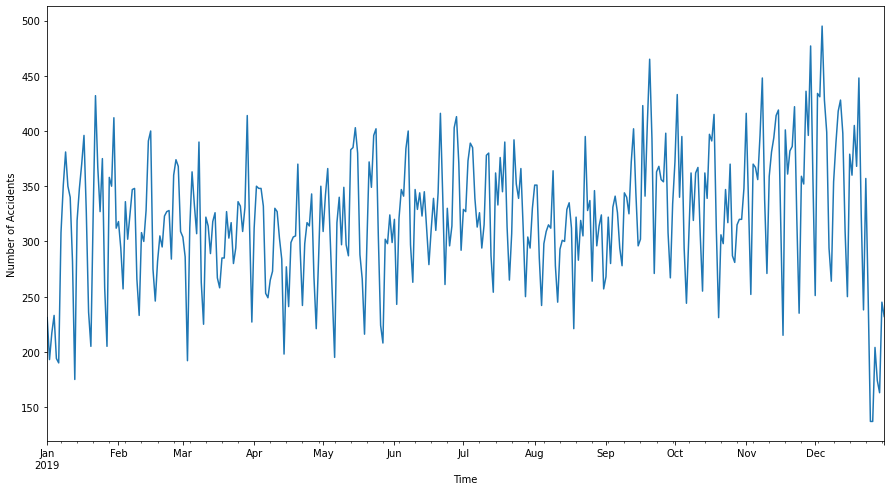

In [ ]:
#Count the n umber of accidents in a given moment, using a variable withou missing values ("Acciudent Severity")
counts = df.groupby(df["Date"]).count()["Accident_Severity"]

#Plot the graph
counts.plot(figsize=(15,8))
plt.xlabel("Time")
plt.ylabel("Number of Accidents")

## **Split the dataset into train and test**

Now that all the variables have been cleaned and set to their correct type, we can proceed splitting the dataset into training and testing set. Besides, as shown in both table and graph below, our target variable classes are not equally distributed, we will need to deal with imbalanced classes, indeed. Hence, when splitting the dataset we will be using the stratify argument to mantain the same class proportions of the target variable in both training and testing set. 

In [ ]:
# Inspect if data is unbalanced, by checking the weights of each accident severity category in the data set
df["Accident_Severity"].value_counts(normalize = True)*100 

Slight     78.658926
Serious    19.930537
Fatal       1.410537
Name: Accident_Severity, dtype: float64

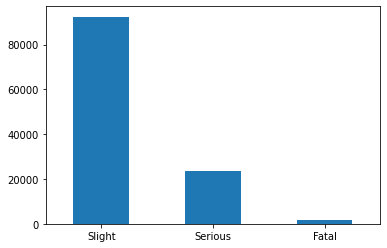

In [ ]:
# Visualise this unbalance using a bar chart
df["Accident_Severity"].value_counts().plot(kind="bar", rot = 0)

In [ ]:
#Split the dataset into training and testing 
train_set, test_set = train_test_split(df, stratify = df["Accident_Severity"], test_size = 0.2, random_state = 42)

In [ ]:
#Check if the split maintained the same proportion within categories for the target
train_set["Accident_Severity"].value_counts(normalize = True)*100 

Slight     78.658835
Serious    19.930196
Fatal       1.410969
Name: Accident_Severity, dtype: float64

In [ ]:
#Check if the split maintained the same proportion within categories for the target
test_set["Accident_Severity"].value_counts(normalize = True)*100 

Slight     78.659289
Serious    19.931900
Fatal       1.408810
Name: Accident_Severity, dtype: float64

# **Exploratory Data Analysis**

We are now going to explore the training set displaying its summary statistics and checking for missing values. The test set will be put aside in order to do not get data snooping issues afterwards.  

In [ ]:
#print the shape of both training and testing set 
print(f"train_set shape: {train_set.shape}")
print(f"test_set shape: {test_set.shape}")

train_set shape: (93978, 18)
test_set shape: (23495, 18)


In [ ]:
#descriptive statistics for the train set numerical variables 
train_set.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit
count,93955.000000,9.395500e+04,93955.000000,93955.000000,93978.000000,93978.000000
mean,452303.733894,2.792356e+05,-1.250835,52.400380,1.841857,36.757933
std,95017.068544,1.510549e+05,1.392316,1.360583,0.708364,14.044245
min,64084.000000,1.081400e+04,-7.525273,49.917760,1.000000,-1.000000
25%,387950.000000,1.756070e+05,-2.182060,51.466992,1.000000,30.000000
50%,459068.000000,2.199750e+05,-1.127875,51.864348,2.000000,30.000000
75%,529379.500000,3.853335e+05,-0.135500,53.362047,2.000000,40.000000
max,655244.000000,1.167366e+06,1.757476,60.388637,17.000000,70.000000


In [ ]:
#descriptive statistics for the train set categorical variables 
train_set.describe(include=["O"])

,Accident_Severity,Day_of_Week,Road_Type,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,season,Time_of_the_Day
count,93978,93978,92270,93977,91250,92919,92586,92774,93955,93978,93978
unique,3,7,5,3,8,5,8,6,2,4,3
top,Slight,Saturday,Single carriageway,Daylight,Fine no high winds,Dry,None,None,Urban,Autumn,Afternoon
freq,73922,15118,68210,66806,73894,65887,90554,91110,63662,25021,46248


In [ ]:
#Check for missing values in train set
train_set.isnull().sum()

Location_Easting_OSGR           23
Location_Northing_OSGR          23
Longitude                       23
Latitude                        23
Accident_Severity                0
Number_of_Vehicles               0
Date                             0
Day_of_Week                      0
Road_Type                     1708
Speed_limit                      0
Light_Conditions                 1
Weather_Conditions            2728
Road_Surface_Conditions       1059
Special_Conditions_at_Site    1392
Carriageway_Hazards           1204
Urban_or_Rural_Area             23
season                           0
Time_of_the_Day                  0
dtype: int64

In [ ]:
#Check for missing values in test set
test_set.isnull().sum()

Location_Easting_OSGR           5
Location_Northing_OSGR          5
Longitude                       5
Latitude                        5
Accident_Severity               0
Number_of_Vehicles              0
Date                            0
Day_of_Week                     0
Road_Type                     429
Speed_limit                     0
Light_Conditions                0
Weather_Conditions            704
Road_Surface_Conditions       286
Special_Conditions_at_Site    420
Carriageway_Hazards           347
Urban_or_Rural_Area             5
season                          0
Time_of_the_Day                 0
dtype: int64

## Univariate Analysis 

Now that we have a general idea of the data, let's focus on the training set. First, we can analyse the distribution of the numerical variables. Doing so, we can also double check for outliers or some sort of missing values that might have been annotated as "99" (common in statistics), "0", etc. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdf13c61d0>,
      dtype=object)

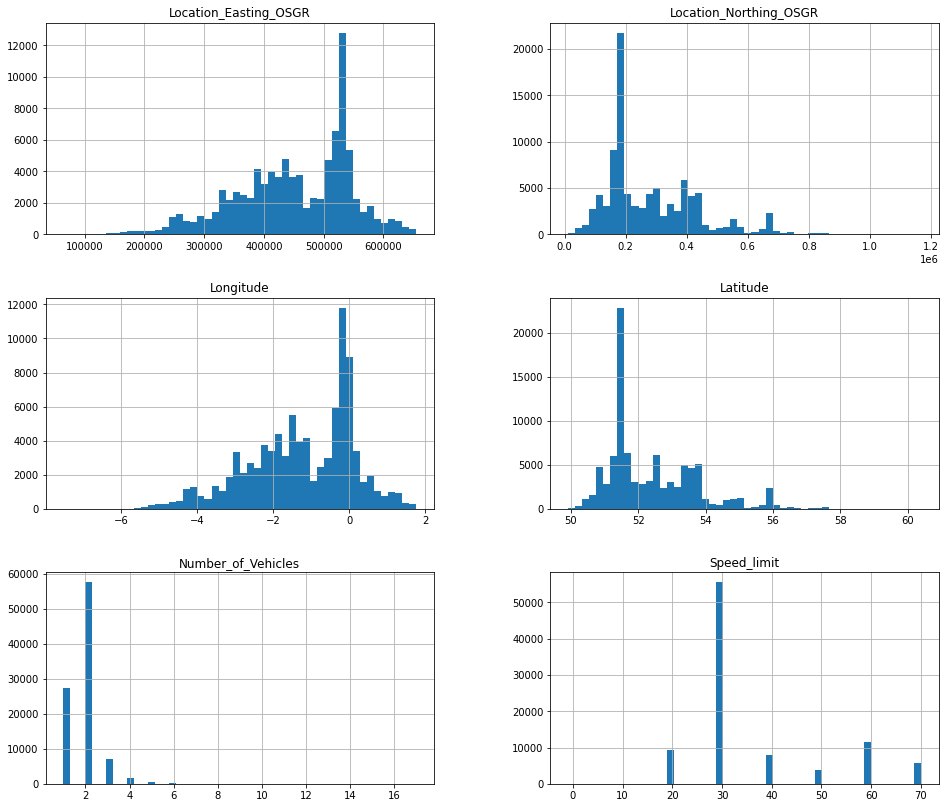

In [ ]:
#Histograms for numerical variables
train_set.hist(bins = 50, figsize = [16, 14])

We can now do the same for the categorical variables in the training set. 

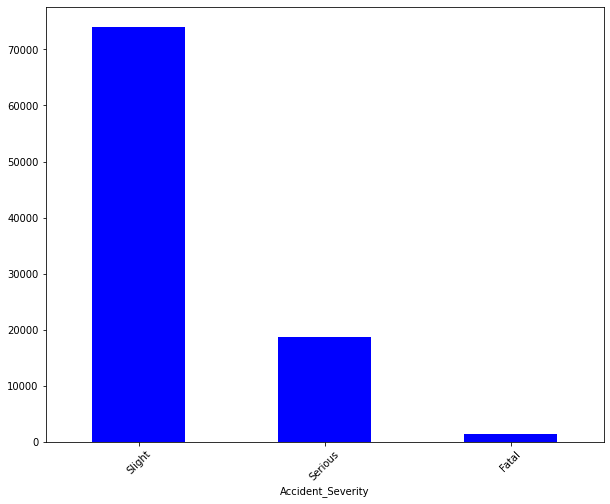

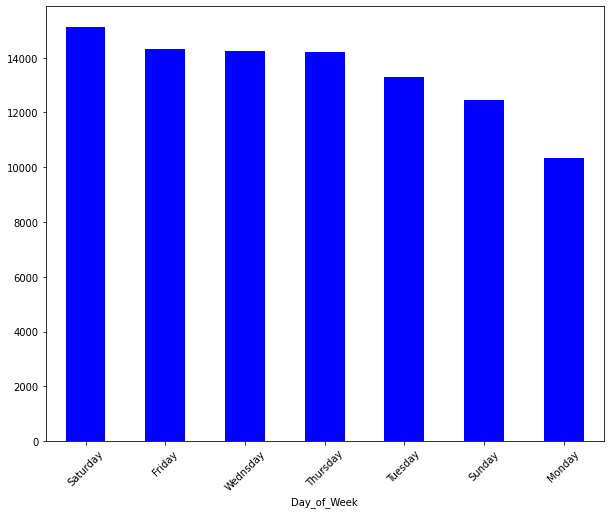

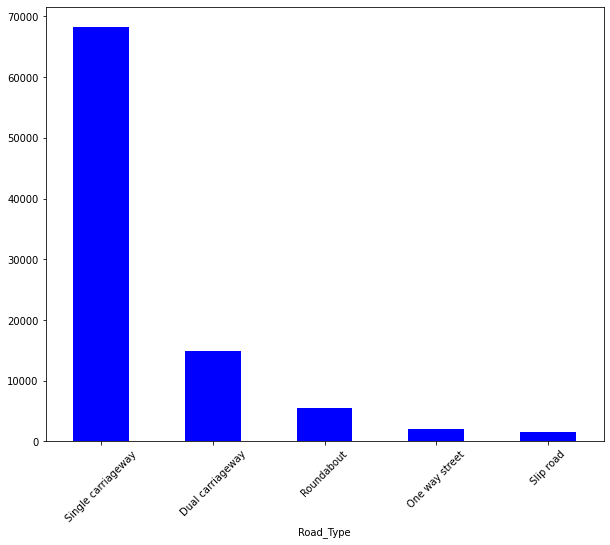

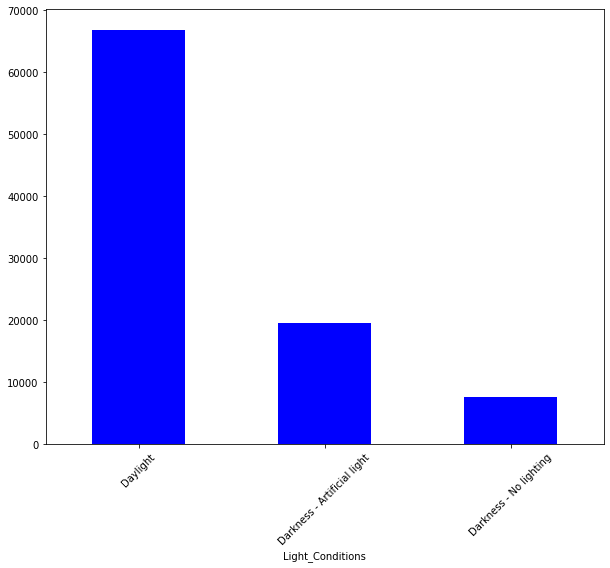

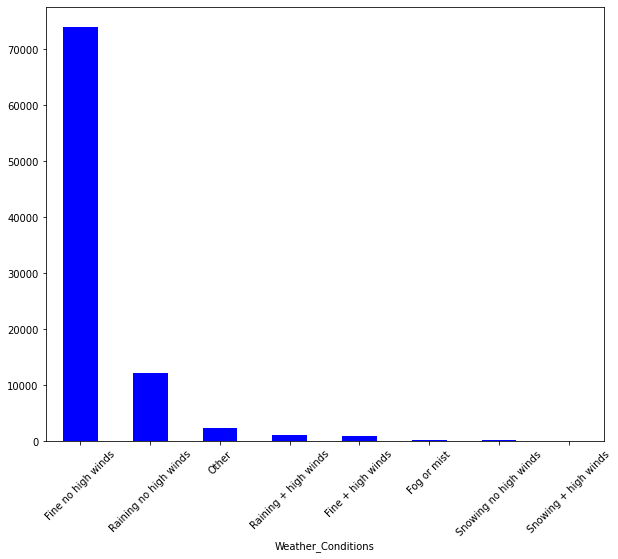

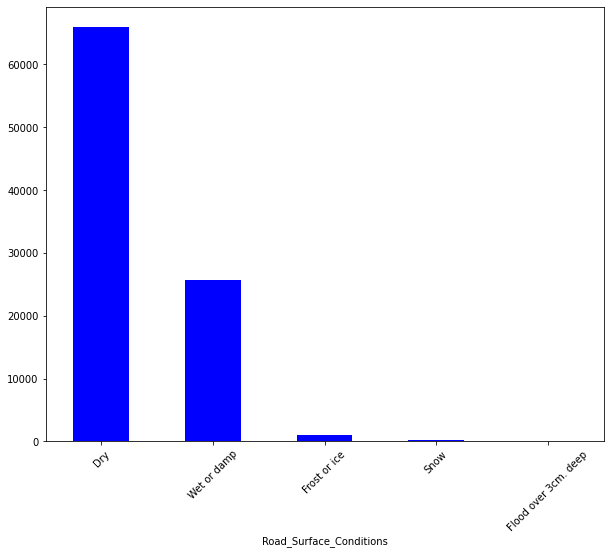

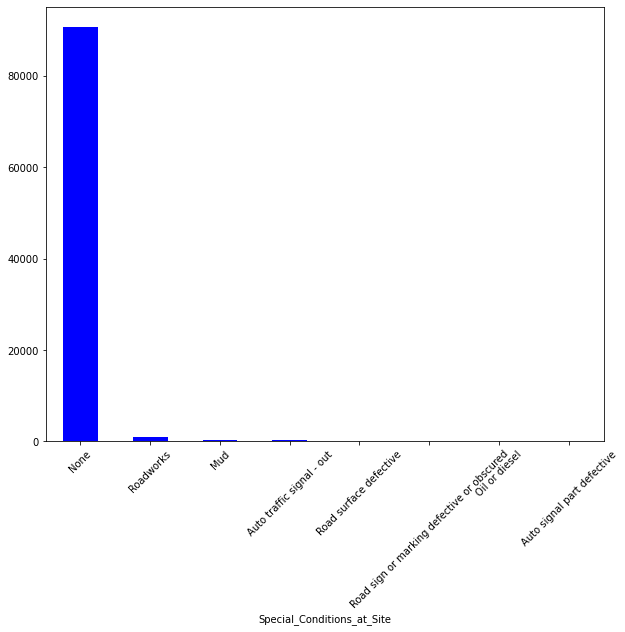

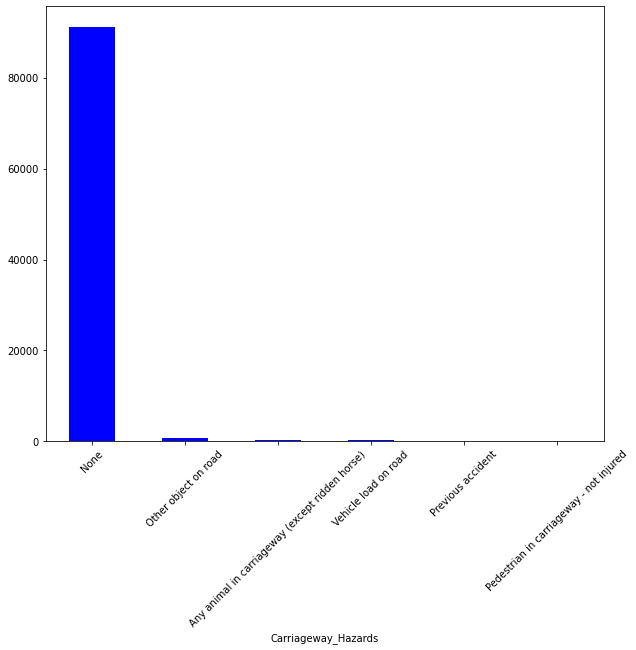

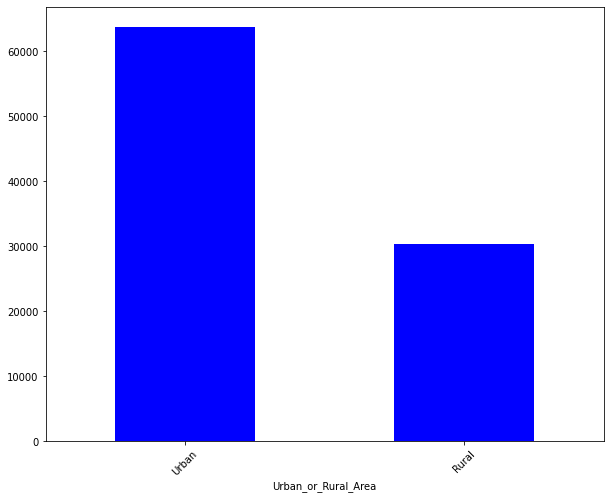

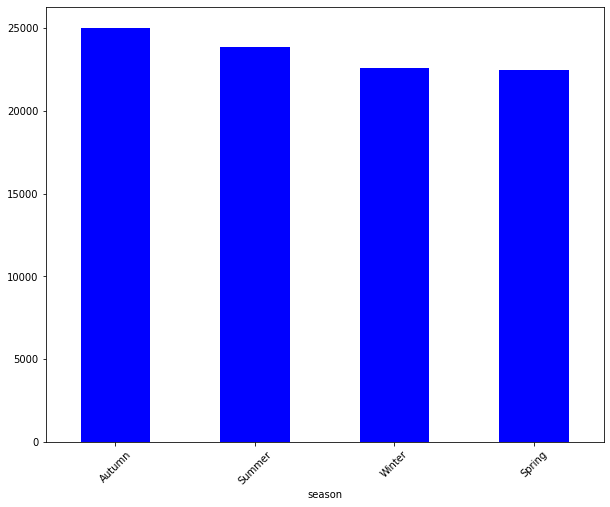

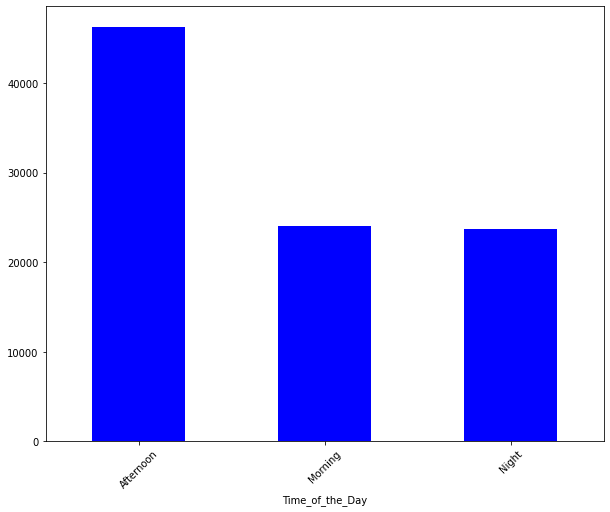

In [ ]:
#Create a new subset with the categorical variables we want plot 
categorical_features = [col for col in train_set.columns if train_set[col].dtypes == "O"]
    
#Iterate over the dataset variables and plot each of them 
for x in categorical_features: 
    train_set[x].value_counts().plot(kind="bar", color = "b", rot=45, figsize=(10,8))
    plt.xlabel(x)
    plt.show()
    print("")
    print("")

Based on the distribution of the variables, we can conclude the following: 
 
*   The number of accidents during the day of the weeks are equivalent, except for Monday where there are less accidents than any other days.
*   The majority of the accidents : 
 *  are slight accidents
 *  happened on single carriageway and on daylight
 *  happened when there were no high winds
 *  happened on dry or wet road.





## Multivariate Analysis 

From the bar charts we can see how a few variables have got quite unbalanced classes, thereby we might want to merge some classes to create a more useful feautre. Let's go a bit deeper, explorying the contingency tables between those variables and our target variable. 

In [ ]:
#Create a function to analyse how the different categorical variables relate to the target variable "Accident Severity"
def cont_table(x,y):
    
    cont_table = pd.crosstab(train_set[x],train_set[y])
    
    return cont_table

In [ ]:
cont_table("Accident_Severity","Special_Conditions_at_Site")

Special_Conditions_at_Site,Auto signal part defective,Auto traffic signal - out,Mud,None,Oil or diesel,Road sign or marking defective or obscured,Road surface defective,Roadworks
Accident_Severity,,,,,,,,
Fatal,0,4,2,1302,3,2,2,11
Serious,7,40,50,18206,38,25,67,172
Slight,25,176,176,71046,104,126,124,878


In [ ]:
cont_table("Accident_Severity","Carriageway_Hazards")

Carriageway_Hazards,Any animal in carriageway (except ridden horse),None,Other object on road,Pedestrian in carriageway - not injured,Previous accident,Vehicle load on road
Accident_Severity,,,,,,
Fatal,4,1301,10,4,5,2
Serious,66,18233,205,30,38,51
Slight,210,71576,601,132,131,175


In [ ]:
cont_table("Accident_Severity","Weather_Conditions")

Weather_Conditions,Fine + high winds,Fine no high winds,Fog or mist,Other,Raining + high winds,Raining no high winds,Snowing + high winds,Snowing no high winds
Accident_Severity,,,,,,,,
Fatal,27,1063,14,18,24,147,0,5
Serious,229,15070,58,357,264,2327,5,48
Slight,737,57761,245,2063,871,9656,24,237


In [ ]:
cont_table("Accident_Severity","Road_Surface_Conditions")

Road_Surface_Conditions,Dry,Flood over 3cm. deep,Frost or ice,Snow,Wet or damp
Accident_Severity,,,,,
Fatal,909,3,11,2,401
Serious,13091,32,203,30,5279
Slight,51887,104,745,161,20061


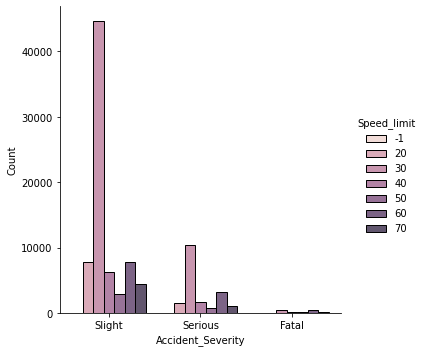

In [ ]:
sns.displot(train_set,x="Accident_Severity",hue="Speed_limit",shrink=.8, multiple="dodge")

Authority usually emphasis on how the speeds increases the likelihood of having an accident. 
Here we can see that the majority of the slight and serious accidents are when the speed limit is 30 mph. 
For the fatal accident the two dominant speed limits are 30 mph and 60 mph.


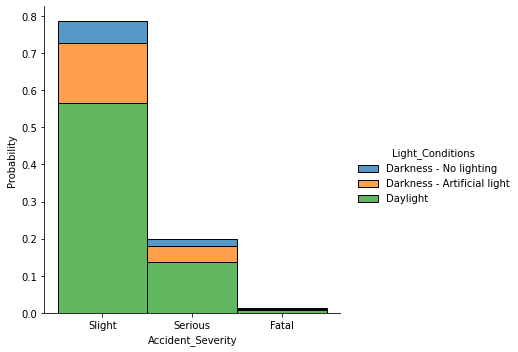

In [ ]:
sns.displot(train_set,x="Accident_Severity", hue="Light_Conditions",multiple="stack",stat="probability")

Nearly 80% of the accidents are slight, 20% of them are serious and the rest if fatal. Most of the accidents appear in daylight and the second most probable case is during darkness when the lights are lit. This means that when there is no light along the road, it does not imply that there will be more road accidents.


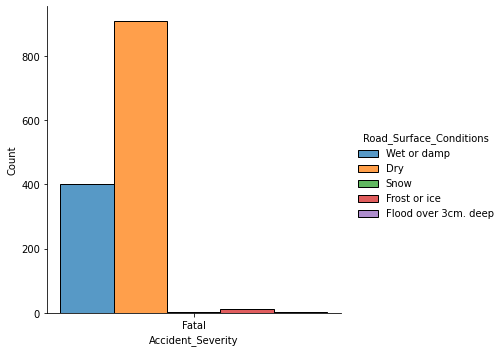

In [ ]:
sns.displot(data = train_set[train_set.Accident_Severity=="Fatal"],x="Accident_Severity",hue="Road_Surface_Conditions",shrink=.8, multiple="dodge")

This graph tells us how the conditions of the road surface impact the amount of fatal accidents. It appears that fatal accidents occur mostly on dry and wet roads and in rare cases on frost or ice. This information can be useful for the authorities as they may want to put effort into signals for slippery wet roads. 

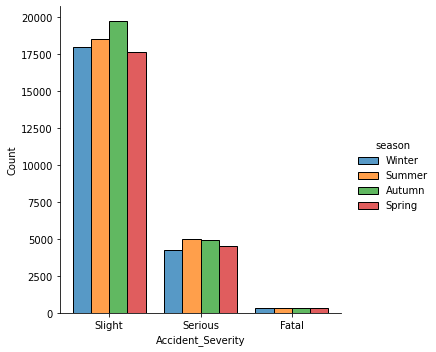

In [ ]:
sns.displot(data = train_set,x="Accident_Severity",hue="season",shrink=.8, multiple="dodge")

There are not so many differences between seasons but Autumn is the season that has the largest number of accidents among others. 

We can also investigate the relationship between the accident severity and both the speed limit and road surface condition when the accident occured. 

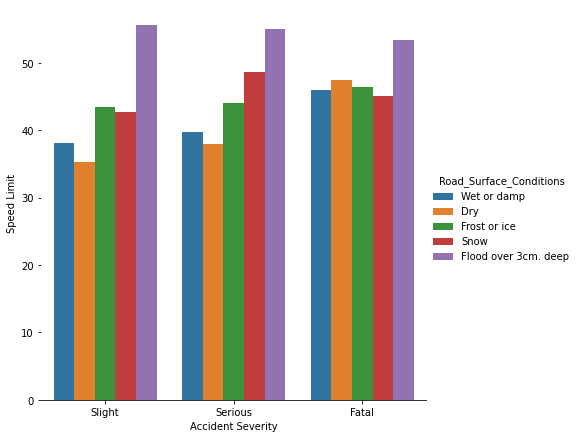

In [ ]:
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(data=train_set, x="Accident_Severity", y="Speed_limit", hue="Road_Surface_Conditions",
                height=6, kind="bar", ci=None)

g.despine(left=True)
g.set_ylabels("Speed Limit")
g.set_xlabels("Accident Severity")

Generally, it appears that all the three different types of accident severity follow the same path. On the x-axes we have got the accident severity classes and on the y-axes the speed limit. Besides, the bars' colour represents the five different road surface conditions at the moment when the accident occured. Interestingly, we can see how on average accidents occured at a lower speed limit when there is  a better road surface condition such as dry or wet. Instead, when there is flood or snow accidents occured on a higher average speed limit. 

Since our business objective is to create a model that aims to help the UK government in better adressing the road safety in the country. It would be interesting to get a better idea on where the most accidents occur and we are able to do so with the Urban_or_Rural_Area variable. However, we will need to convert it as a numerical variable again in order to achieve our goal. Lastly, we will just eliminate the numerical version of the variable. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


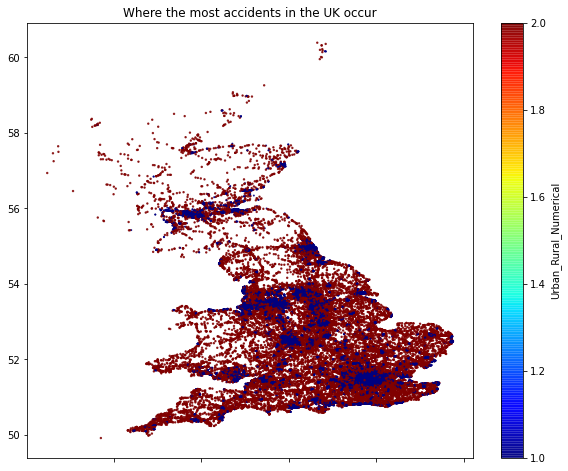

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Creating a Urban_Rural_Area variable whihc is numerical 
dict = {"Urban": 1, "Rural":2}
train_set["Urban_Rural_Numerical"] = train_set["Urban_or_Rural_Area"].map(dict)

#Display a scatter plots to to see where the majority of accidents occure
train_set.plot(kind="scatter",
            x="Longitude",
            y="Latitude", 
            alpha=0.8,                              # transparency
            s="Urban_Rural_Numerical",
            c="Urban_Rural_Numerical",                # colour of the dot: house value
            cmap=plt.get_cmap("jet"),               # colour map to use
            colorbar=True,                          # show the color map
            figsize=[10,8]
)

plt.title("Where the most accidents in the UK occur")
plt.ylabel("")
plt.show()

#drop the Urban_Rural_Numerical variable 
train_set.drop("Urban_Rural_Numerical", axis = 1, inplace=True)

The graph clearly represents the UK. Besides, the blue dots represents the urban areas and the red dots the rural areas in the island. The higher the dots' density, the higher the number of accidents occured in that area. 

We can now exploring some relationships between our target variable and two other variables such as the Speed_limit and the Number_of_Vehicles 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdf04f5ad0>,
      dtype=object)

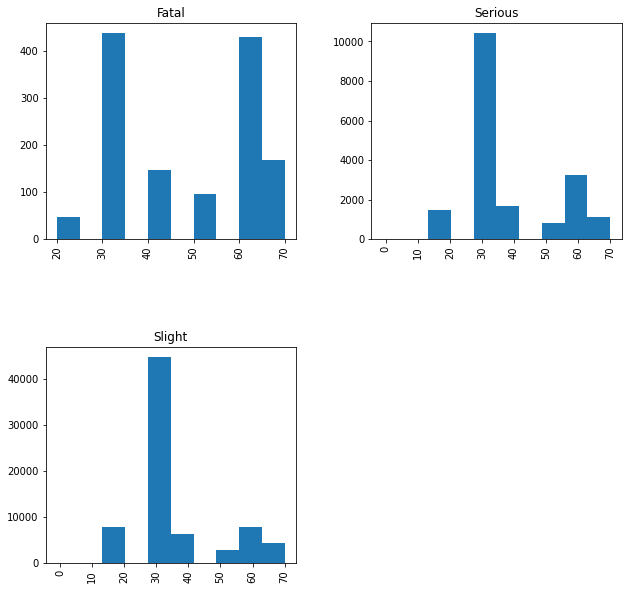

In [ ]:
train_set["Speed_limit"].hist(by = train_set["Accident_Severity"], figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdf0377990>,
      dtype=object)

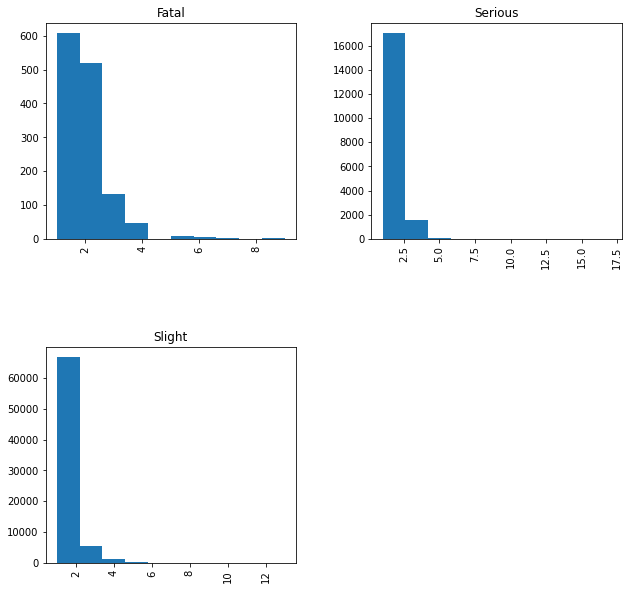

In [ ]:
train_set["Number_of_Vehicles"].hist(by = train_set["Accident_Severity"], figsize=(10,10))

Lastly, we can analyse the correlation between the numerical features in the training set to get an even better idea to what is relationships amongst those variables. This information might be useful later on in the analysis when we will build the models. 

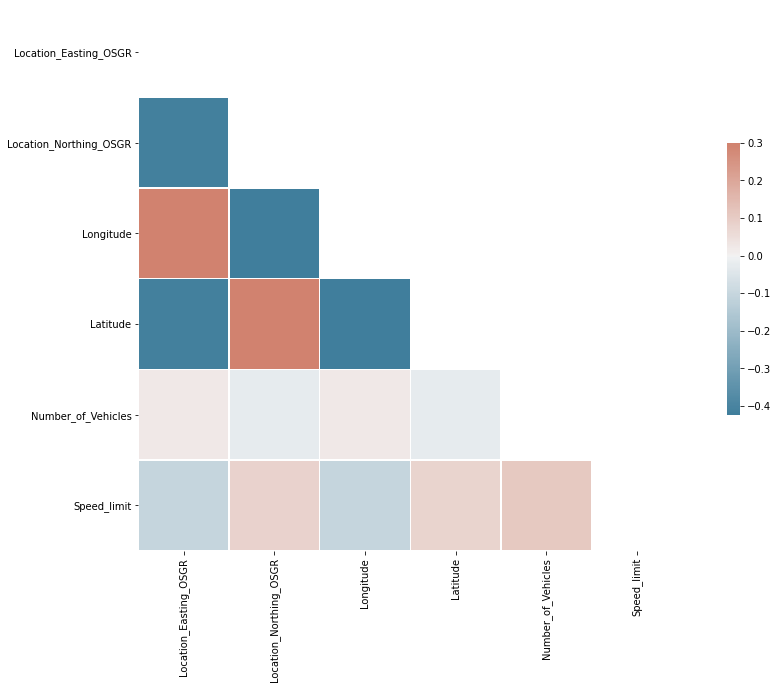

In [ ]:
#correlation matrix 
corr = train_set.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The detacted correlation range goes from -0.4 up to 0.3, thereby we can state that there is no multicollinearity amonsgt our numerical features. Though, we can see that there is a correlation between the Logitute and Latitute with Location Easting and Location Northing, this is probably due to the fact that those variables measure a position of one point in the world, hence the higer the Longitute the higher the Location  Easting, and the higher the Latitute the higher the Location Northing, and viceversa. 

# **Data preprocessing** 

## Imputing the Missing Values 

It is now necessary to address missing values. The way to go, is using simple imputer. Because we have numeric and categorical variables, we have to impute missing values based on two different approaches. For numeric ones, the median was used to impute values, this way we get a more robust analysis against possible outliers, while making sure that no decimal nuumbers are added to all ordinal variables; For categorical, we will use the most common observation to impute values.
For the process to become smoother, a list with nimerical and categorical variables was used to iterate over them.

In [ ]:
# date should be excluded from the numerical features
numerical_features = [col for col in train_set.columns if (train_set[col].dtypes != "O")  & (col != "Date")]

numerical_features

['Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Latitude',
 'Number_of_Vehicles',
 'Speed_limit']

In [ ]:
#Check if numerical features were correctly selected
train_set[numerical_features].head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit
Accident_Index,,,,,,
2019970907872,255074.0,656065.0,-4.312110,55.776124,1,30
2019160875736,511401.0,430798.0,-0.311609,53.761655,1,20
2019521902855,360255.0,177516.0,-2.573907,51.495178,1,30
2019010198994,538322.0,172703.0,-0.011353,51.436445,3,20
2019320299438,511833.0,371473.0,-0.326174,53.228558,1,60


In [ ]:
#Create list with categorical variables, excluding the target variable "Accident Severity"
categorical_features = [col for col in train_set.columns if (train_set[col].dtypes == "O") & (col != "Accident_Severity")]
categorical_features

['Day_of_Week',
 'Road_Type',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'season',
 'Time_of_the_Day']

In [ ]:
#Check if categorical features were correctly selected
train_set[categorical_features].head()

,Day_of_Week,Road_Type,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,season,Time_of_the_Day
Accident_Index,,,,,,,,,,
2019970907872,Wednsday,Single carriageway,Darkness - No lighting,Raining + high winds,Wet or damp,None,None,Urban,Winter,Morning
2019160875736,Saturday,Single carriageway,Darkness - Artificial light,Fine no high winds,Dry,None,None,Urban,Summer,Night
2019521902855,Wednsday,Single carriageway,Daylight,Fine no high winds,Dry,None,None,Urban,Winter,Morning
2019010198994,Monday,Single carriageway,Daylight,Fine no high winds,Dry,None,None,Urban,Summer,Afternoon
2019320299438,Tuesday,Single carriageway,Daylight,Raining no high winds,Wet or damp,None,None,Rural,Summer,Afternoon


Check for missing values in the entire train set 

In [ ]:
train_set.isnull().sum()

Location_Easting_OSGR           23
Location_Northing_OSGR          23
Longitude                       23
Latitude                        23
Accident_Severity                0
Number_of_Vehicles               0
Date                             0
Day_of_Week                      0
Road_Type                     1708
Speed_limit                      0
Light_Conditions                 1
Weather_Conditions            2728
Road_Surface_Conditions       1059
Special_Conditions_at_Site    1392
Carriageway_Hazards           1204
Urban_or_Rural_Area             23
season                           0
Time_of_the_Day                  0
dtype: int64

In [ ]:
# we create a temporary subset with only numerical columns, 
# but keep the categorical columns in a separate variable

trainset_categorical = train_set[categorical_features]
trainset_numerical = train_set[numerical_features]

testset_categorical = test_set[categorical_features]
testset_numerical = test_set[numerical_features]

In [ ]:
#Instatiate two different imputer, one for categorical features and the other for numerical features 
cat_imputer = SimpleImputer(strategy="most_frequent") 
num_imputer = SimpleImputer(strategy="median")

In [ ]:
#Fit and tranform the two imputer on the train set 
train_cat_transformed = cat_imputer.fit_transform(trainset_categorical)
train_num_transformed = num_imputer.fit_transform(trainset_numerical)

#Transorm the test set 
test_cat_transformed = cat_imputer.transform(testset_categorical)
test_num_transformed = num_imputer.transform(testset_numerical)

In [ ]:
#Create the dataframes with the categorical and numerical variables with no missing values: both for train and test sets
trainset_categorical = pd.DataFrame(train_cat_transformed, columns=categorical_features)
trainset_numerical = pd.DataFrame(train_num_transformed, columns=numerical_features)

testset_categorical = pd.DataFrame(test_cat_transformed , columns=categorical_features)
testset_numerical = pd.DataFrame(test_num_transformed, columns=numerical_features)

In [ ]:
#Check nulls in the categorical train dataset
trainset_categorical.isnull().sum() 

Day_of_Week                   0
Road_Type                     0
Light_Conditions              0
Weather_Conditions            0
Road_Surface_Conditions       0
Special_Conditions_at_Site    0
Carriageway_Hazards           0
Urban_or_Rural_Area           0
season                        0
Time_of_the_Day               0
dtype: int64

In [ ]:
#Check nulls in the numerical train dataset
trainset_numerical.isnull().sum() 

Location_Easting_OSGR     0
Location_Northing_OSGR    0
Longitude                 0
Latitude                  0
Number_of_Vehicles        0
Speed_limit               0
dtype: int64

## Feature Engineering 

As concluded in the DEA part, some variables do not portray useful information to withdraw conclusions on the specific business problem being addressed here. This way, the following code will allow us to create variables and merge categories within variables to make sure any conclusions taken are more significant and sound.

Starting with Carriageway Hazards. Create two new categories: Road Hazard and Carriageway Hazard to discern between specific conditions in either one of the categories. Each of them will include all the considerations encountered either in road or carriageway. This was, it is possible to outline focus areas to act upon and see their relevance to accident severity.

In [ ]:
#Check categories in the carriageway hazards variable
trainset_categorical["Carriageway_Hazards"].value_counts()

None                                               92314
Other object on road                                 816
Any animal in carriageway (except ridden horse)      280
Vehicle load on road                                 228
Previous accident                                    174
Pedestrian in carriageway - not injured              166
Name: Carriageway_Hazards, dtype: int64

In [ ]:
def replace_Carriageway_Hazards(x): 

  #Replace all the values containg road with road hazard, 
  #Replace all the values containing carriegeway with carriegeway hazard
  #Replace none to no 
    if ("road" or "previous accident") in x["Carriageway_Hazards"]: 
        return "Road Hazard" 
    elif "carriageway" in x["Carriageway_Hazards"]: 
        return "Carriegeway Hazard"
    else: 
        return "None"

#Apply the function to the Light Condition column 
trainset_categorical["Hazards"] = trainset_categorical.apply(replace_Carriageway_Hazards, axis = 1)  
testset_categorical["Hazards"] = testset_categorical.apply(replace_Carriageway_Hazards, axis = 1)  


#Check the train value 
print(f"train: {trainset_categorical.Hazards.value_counts()}")

print("")
print("")

#Check the test value 
print(f"test: {testset_categorical.Hazards.value_counts()}")

train: None                  92488
Road Hazard            1044
Carriegeway Hazard      446
Name: Hazards, dtype: int64


test: None                  23110
Road Hazard             261
Carriegeway Hazard      124
Name: Hazards, dtype: int64


In [ ]:
#Drop the carriageway hazards variable from both datasets
trainset_categorical.drop(["Carriageway_Hazards"], axis = 1, inplace = True) 
testset_categorical.drop(["Carriageway_Hazards"], axis = 1, inplace = True) 

Weather conditions. Create two variables: one for winds and another for any kind of precipitation, rather than having everything mixed together. This gives us a real understanding of weather conditions at site and if they are related to accidents occuring as well as their severity.

In [ ]:
# create a column called high winds
def highwinds_converter(row):
    """      
    Return True is high winds, False otherwise
    """
    if ("no high winds" not in row["Weather_Conditions"] and "high winds" in row["Weather_Conditions"]): 
        return "True"
    else: 
        return "False"

#Apply the func on high winds 
trainset_categorical["high_winds"] = trainset_categorical.apply(highwinds_converter, axis = 1)  
testset_categorical["high_winds"] = testset_categorical.apply(highwinds_converter, axis = 1)  

#Check the values within high winds 
trainset_categorical["high_winds"].value_counts()
testset_categorical["high_winds"].value_counts()

False    22980
True       515
Name: high_winds, dtype: int64

In [ ]:
# remove "high winds" from Weather_Conditions
trainset_categorical["Weather_Conditions"] = trainset_categorical["Weather_Conditions"].str.replace(" no high winds", "")
trainset_categorical["Weather_Conditions"] = trainset_categorical["Weather_Conditions"].str.replace(" \+ high winds", "")

testset_categorical["Weather_Conditions"] = testset_categorical["Weather_Conditions"].str.replace(" no high winds", "")
testset_categorical["Weather_Conditions"] = testset_categorical["Weather_Conditions"].str.replace(" \+ high winds", "")

# rename Weather_Conditions to "precipitation"
trainset_categorical= trainset_categorical.rename(columns={"Weather_Conditions": "precipitation"})
testset_categorical= testset_categorical.rename(columns={"Weather_Conditions": "precipitation"})

In [ ]:
#Check if changes were correctly accomplished
trainset_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93978 entries, 0 to 93977
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Day_of_Week                 93978 non-null  object
 1   Road_Type                   93978 non-null  object
 2   Light_Conditions            93978 non-null  object
 3   precipitation               93978 non-null  object
 4   Road_Surface_Conditions     93978 non-null  object
 5   Special_Conditions_at_Site  93978 non-null  object
 6   Urban_or_Rural_Area         93978 non-null  object
 7   season                      93978 non-null  object
 8   Time_of_the_Day             93978 non-null  object
 9   Hazards                     93978 non-null  object
 10  high_winds                  93978 non-null  object
dtypes: object(11)
memory usage: 7.9+ MB


Special Conditions at site. Split into road defects and oil/mud. Regardless of the defect, we are interested in knowing if accidents are cause by road related conditions that are preventable, or other conditions that are out of the agency's control (like petro on the road).

In [ ]:
#Check categories in the special conditions at site variable
trainset_categorical["Special_Conditions_at_Site"].value_counts()

None                                          91946
Roadworks                                      1061
Mud                                             228
Auto traffic signal - out                       220
Road surface defective                          193
Road sign or marking defective or obscured      153
Oil or diesel                                   145
Auto signal part defective                       32
Name: Special_Conditions_at_Site, dtype: int64

In [ ]:
def replace_Special_Conditions_at_Site(x): 

  #Replace all the values containing mud or oil and diesel in mud or petrol  
  #Replace all the values related to road defect in road defect 
  #Keep everithing else the same as it is 

    if "None" in x["Special_Conditions_at_Site"]: 
        return "None" 
    elif ("Mud" or "Oil or Diesel") in x["Special_Conditions_at_Site"]: 
        return "Mud or Petrol"
    else: 
        return "Road Defect"

#Apply the function to the Light Condition column 
trainset_categorical["Special_Conditions_at_Site"] = trainset_categorical.apply(replace_Special_Conditions_at_Site, axis = 1)  
testset_categorical["Special_Conditions_at_Site"] = testset_categorical.apply(replace_Special_Conditions_at_Site, axis = 1)  


#Check the value 
print(f"train: {trainset_categorical.Special_Conditions_at_Site.value_counts()}")

print("")
print("")

print(f"test: {testset_categorical.Special_Conditions_at_Site.value_counts()}")


train: None             91946
Road Defect       1804
Mud or Petrol      228
Name: Special_Conditions_at_Site, dtype: int64


test: None             22970
Road Defect        458
Mud or Petrol       67
Name: Special_Conditions_at_Site, dtype: int64


Road Surface conditions. More concised categories were created. Water includes flooding (as this is quite neglectable within the dataset) and wet and snow will include frost and snow due to their similarity.

In [ ]:
#Check categories in the road surface conditions variable
trainset_categorical["Road_Surface_Conditions"].value_counts(normalize=True)

Dry                     0.712358
Wet or damp             0.273905
Frost or ice            0.010205
Snow                    0.002054
Flood over 3cm. deep    0.001479
Name: Road_Surface_Conditions, dtype: float64

In [ ]:
def replace_Road_Surface_Conditions(x): 

  #Replace all the values containing mud or oil and diesel in mud or petrol  
  #Replace all the values related to road defect in road defect 
  #Keep everithing else the same as it is 

    if ("Wet" or "Flood") in x["Road_Surface_Conditions"]: 
        return "Water" 
    elif ("Snow" or "Frost") in x["Road_Surface_Conditions"]: 
        return "Snow"
    else: 
        return "Dry"

#Apply the function to the Light Condition column 
trainset_categorical["Road_Surface_Conditions"] = trainset_categorical.apply(replace_Road_Surface_Conditions, axis = 1)  
testset_categorical["Road_Surface_Conditions"] = testset_categorical.apply(replace_Road_Surface_Conditions, axis = 1)  


#Check the value 
print(f"train: {trainset_categorical.Road_Surface_Conditions.value_counts()}")

print("")
print("")

print(f"test: {testset_categorical.Road_Surface_Conditions.value_counts()}")


train: Dry      68044
Water    25741
Snow       193
Name: Road_Surface_Conditions, dtype: int64


test: Dry      16943
Water     6500
Snow        52
Name: Road_Surface_Conditions, dtype: int64


## One Hot Encoding 

Once the data is all cleaned and ready for model creation, it is necessary to make one extra step: Creating dummis for all the categorical variables to be used in the modeling part of the work. One Hot Encoder will be used to generate those dummy variables.
Note: Because some variables were created previously and others were dropped, the list of categorical features was updated to include these changes.

In [ ]:
#Add Hazards to the categorical features list 
categorical_features.append("Hazards")
categorical_features.append("precipitation")

#Remove Carriageway Hazards from the list 
categorical_features.remove("Carriageway_Hazards")
categorical_features.remove("Weather_Conditions")

In [ ]:
#Check if the list was updated
categorical_features

['Day_of_Week',
 'Road_Type',
 'Light_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Urban_or_Rural_Area',
 'season',
 'Time_of_the_Day',
 'Hazards',
 'precipitation']

In [ ]:
def get_dummies(train_set, test_set, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    # To avoid multicollinearity, use drop="first"
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    cat_vals = train_set[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **trainset**
    
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        train_set[new_col_name] = transformed[:,i]
    
    # transform the **testset** using the fitted encoder
    
    cat_vals = test_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)

    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        test_set[new_col_name] = transformed[:,i]
    
    return train_set, test_set

In [ ]:
#apply the one hot encoder to every categorical variable in the dataset to get dummies
for variable in categorical_features:
    train_cat_dummy, test_cat_dummy =  get_dummies(trainset_categorical, testset_categorical, variable)

In [ ]:
#Delete the original categorical variable columns
for col_name in categorical_features:
    del train_cat_dummy[col_name]
    del test_cat_dummy[col_name]

In [ ]:
#Check if dummies were corrctly obtained
train_cat_dummy.head()

,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing
0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Scaling Numerical Features

The last preprocessing technique we will need to apply would be to scaling the features. Indeed, we have seen in the EDA section the wideness on the minumum and maximum values of our numerical features. Hence, it will be beneficial for our model to recscale those features. 

In [ ]:
#Instantiate the scaler 
robust_scaler = RobustScaler()

In [ ]:
#Fit and tranform the two imputer on the train set 
train_num_scaled = robust_scaler.fit_transform(trainset_numerical)

#Transorm the test set 
test_num_scaled = robust_scaler.transform(testset_numerical)

## Final Training and Testing set 

At this point, we will join the variables (categorical and numerical) into two datasets: final_trainset and final_testset.

In [ ]:
# Get the final train and test sets for numerical variables
trainset_numerical = pd.DataFrame(train_num_scaled, columns= numerical_features)

testset_numerical = pd.DataFrame(test_num_scaled, columns= numerical_features)

In [ ]:
# Get the final train and test sets by joining the numerical and categorical sets of data fully transformed
final_trainset_transormed = pd.concat([trainset_numerical, train_cat_dummy], axis = 1) 

final_testset_transormed = pd.concat([testset_numerical, test_cat_dummy], axis = 1) 

In [ ]:
# Check if the final trainset is fully operational
final_trainset_transormed.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing
0,-1.442574,2.079796,-1.556315,2.064596,-1.0,0.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.370081,1.005455,0.398955,1.001380,-1.0,-1.0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.698771,-0.202495,-0.706757,-0.194844,-1.0,0.0,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.560456,-0.225449,0.545707,-0.225843,1.0,-1.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.373136,0.722523,0.391836,0.720016,-1.0,3.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Check if the final testset is fully operational
final_testset_transormed.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing
0,0.551709,-0.174657,0.539034,-0.175172,0.0,-1.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.020105,0.371138,-0.021451,0.375125,-1.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.901458,0.802979,-0.929677,0.803902,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.463066,-0.270284,0.447309,-0.268751,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.474161,-0.393658,0.453869,-0.391643,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Adding the target variable to the transformed train set 
final_trainset = pd.concat([final_trainset_transormed, train_set["Accident_Severity"].reset_index().drop("Accident_Index", axis = 1)], axis = 1)

#Adding the target variable to the transformed test set 
final_testset = pd.concat([final_testset_transormed, test_set["Accident_Severity"].reset_index().drop("Accident_Index", axis = 1)], axis = 1)

In [ ]:
#Check trainset shape
final_trainset.shape

(93978, 35)

In [ ]:
#Check testset shape
final_testset.shape

(23495, 35)

In [ ]:
final_trainset.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing,Accident_Severity
0,-1.442574,2.079796,-1.556315,2.064596,-1.0,0.0,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Slight
1,0.370081,1.005455,0.398955,1.001380,-1.0,-1.0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Slight
2,-0.698771,-0.202495,-0.706757,-0.194844,-1.0,0.0,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Slight
3,0.560456,-0.225449,0.545707,-0.225843,1.0,-1.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slight
4,0.373136,0.722523,0.391836,0.720016,-1.0,3.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Slight


In [ ]:
final_testset.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing,Accident_Severity
0,0.551709,-0.174657,0.539034,-0.175172,0.0,-1.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Slight
1,-0.020105,0.371138,-0.021451,0.375125,-1.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Serious
2,-0.901458,0.802979,-0.929677,0.803902,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Slight
3,0.463066,-0.270284,0.447309,-0.268751,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slight
4,0.474161,-0.393658,0.453869,-0.391643,0.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slight


In [ ]:
# Export the datasets
final_testset.to_csv('final_testset.csv', index=False)
final_trainset.to_csv('final_trainset.csv', index=False) 

NameError: ignored